In [1]:
!nvidia-smi

Sun Dec  8 23:54:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    34W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install -q kaggle

In [0]:
# from google.colab import files
# uploaded = files.upload()

MessageError: ignored

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!echo '{"username":"karentree","key":"ff57b9d030d708de9af1a8da9558d6df"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d karentree/artchallenge-118-artists-classification
!unzip artchallenge-118-artists-classification.zip


100% 2.97G/2.97G [00:41<00:00, 104MB/s] 
100% 2.97G/2.97G [00:41<00:00, 76.3MB/s]
Archive:  artchallenge-118-artists-classification.zip
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_1.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_10.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_11.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_12.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_13.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_14.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_15.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_16.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_17.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_18.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_19.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_2.jpg  
  inflating: images/Albrecht_Altdorfer/Albrecht_Altdorfer_20.j

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.callbacks import *
from keras.initializers import *
from keras.preprocessing.image import ImageDataGenerator


from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


Using TensorFlow backend.


In [10]:

artist_all = pd.read_csv('artists_all.csv')
artist_all

,Unnamed: 0,name,years,genre,nationality,paintings,number_of_genre
0,0,Amedeo Modigliani,1884 - 1920,['Expressionism'],['Italian'],193,1
1,1,Vasiliy Kandinskiy,1866 - 1944,"['Expressionism', 'Abstractionism']",['Russian'],88,2
2,2,Diego Rivera,1886 - 1957,"['Social Realism', 'Muralism']",['Mexican'],70,2
3,3,Claude Monet,1840 - 1926,['Impressionism'],['French'],73,1
4,4,Rene Magritte,1898 - 1967,"['Surrealism', 'Impressionism']",['Belgian'],194,2
...,...,...,...,...,...,...,...
113,113,Nikolai Ge,1831 – 1894,['Realism'],['Russian'],43,1
114,114,Robert Campin,1375 – 1444,['Northern Renaissance'],['Flemish'],42,1
115,115,Fyodor Rokotov,1736 – 1808,['Rococo'],['Russian'],32,1
116,116,Rockwell Kent,1882 – 1971,['Realism'],['American'],51,1


In [11]:
# artist_all = artist_all[artist_all['paintings']>200]
artists = artist_all['name'].map(lambda x: x.replace('Albrecht_Dürer','Albrecht_DuтХа├кrer')).map(lambda x: x.replace(' ','_'))
# artists = artist_all['name'].map(lambda x: x.replace('Albrecht_Dürer','Albrecht_DuтХа├кrer'))
len(artists)

118

IndexError: ignored

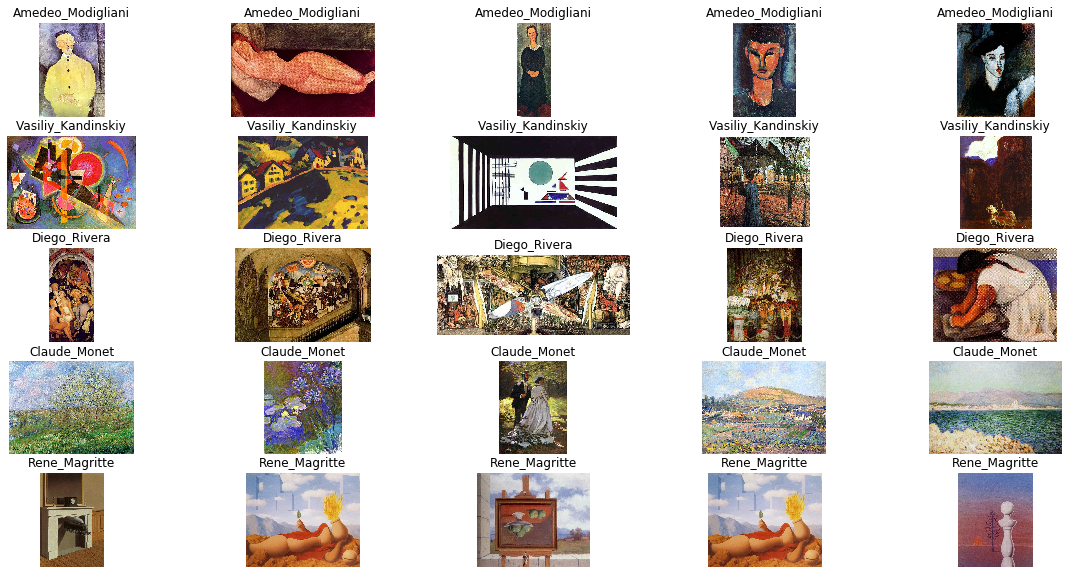

In [12]:
n = 5
fig, axes = plt.subplots(5, n, figsize=(20,10))

artist_dir = '/content/images/'
for i, artist in enumerate(artists):
  for j in range(n):
    random_image_file = random.choice(os.listdir(artist_dir+artist))
    #print(random_image_file)
    image = plt.imread(os.path.join(artist_dir,artist,random_image_file))
    axes[i][j].imshow(image)
    axes[i][j].axis('off')
    axes[i][j].set_title(artist)
plt.show()

In [0]:
# Initialize the data augmenter as an empty image data generator
aug = ImageDataGenerator(validation_split=0.2,
                         rescale=1./255.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True)

In [0]:
art_list= artists.tolist()

In [15]:
batch_size = 12
train_input_shape = (224, 224, 3)

train_generator = aug.flow_from_directory(directory=artist_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=art_list
                                                   )
valid_generator = aug.flow_from_directory(directory=artist_dir,
                                               class_mode='categorical',
                                               target_size=train_input_shape[0:2],
                                               batch_size=batch_size,
                                               subset="validation",
                                               shuffle=True,
                                               classes=art_list)
#??
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 13934 images belonging to 118 classes.
Found 3419 images belonging to 118 classes.
Total number of batches = 1161 and 284


In [0]:
np.random.seed(1000)
n_class = 118

def CNN_model(img_shape=(224, 224, 3), n_classes=n_class, l2_reg=0.,
	weights=None):

  CNN = Sequential()

  #add model conv layer 1
  CNN.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(224,224,3),padding = 'valid'))
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2)))
  
  #add model conv layer 2  
  CNN.add(Conv2D(64, (2, 2))) 
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2)))
  
  #add model conv layer 3
  CNN.add(Conv2D(64, (2, 2))) 
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2))) 

  #add model conv layer 4
  CNN.add(Conv2D(64, (2, 2))) 
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2))) 
  
  #add model conv layer 5
  CNN.add(Conv2D(64, (2, 2))) 
  CNN.add(Activation('relu')) 
  CNN.add(MaxPooling2D(pool_size=(2, 2))) 

  #flatten and fully connect
  CNN.add(Flatten()) 
  CNN.add(Dense(64)) 
  CNN.add(Activation('relu')) 
  CNN.add(Dropout(0.5)) 
    
  #fully connect
  CNN.add(Dense(64)) 
  CNN.add(Activation('relu')) 
  CNN.add(Dropout(0.5)) 

  #fully connect
  CNN.add(Dense(64)) 
  CNN.add(Activation('relu')) 
  CNN.add(Dropout(0.5)) 

  CNN.add(Dense(118)) 
  CNN.add(Activation('softmax')) 

  return CNN


In [17]:
cnn = CNN_model()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [0]:
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [20]:
history1 = cnn.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16
                             )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/30





1161/1161 [==============================] - 411s 354ms/step - loss: 4.5257 - acc: 0.0437 - val_loss: 4.4327 - val_acc: 0.0511
Epoch 2/30
1161/1161 [==============================] - 400s 345ms/step - loss: 4.4624 - acc: 0.0502 - val_loss: 4.4321 - val_acc: 0.0514
Epoch 3/30
1161/1161 [==============================] - 399s 344ms/step - loss: 4.4569 - acc: 0.0481 - val_loss: 4.4325 - val_acc: 0.0514
Epoch 4/30
1161/1161 [==============================] - 395s 340ms/step - loss: 4.4558 - acc: 0.0490 - val_loss: 4.4317 - val_acc: 0.0499
Epoch 5/30
1161/1161 [==============================] - 398s 343ms/step - loss: 4.4546 - acc: 0.0494 - val_loss: 4.4283 - val_acc: 0.0525
Epoch 6/30
1161/1161 [==============================] - 393s 339ms/step - loss: 4.4524 - acc: 0.0497 - val_loss: 4.4296 - val_acc: 0.0511
Epoch 7/30
1161/1161 [==============================] - 394s 339ms/ste

In [0]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger("cnn_history_artist_log.csv", append=True)

In [22]:
!cp /content/cnn_history_artist_log.csv /content/gdrive/My\ Drive/

cp: cannot stat '/content/cnn_history_artist_log.csv': No such file or directory


In [0]:
path = "/content/CNN_model_genre_1114_scratch_artist.h5" 
cnn.save_weights('/content/_model_genre_1114_scratch.h5')


In [0]:
his = pd.DataFrame(history1.history) 
his.to_csv('/content/history_artist.csv')